<a href="https://colab.research.google.com/github/Swastik200/30DaysOfDSA/blob/main/K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp "/content/drive/MyDrive/CMAPSS.zip" "/content"
!unzip CMAPSS.zip

Archive:  CMAPSS.zip
  inflating: CMAPSS/readme.txt       
  inflating: CMAPSS/RUL_FD001.txt    
  inflating: CMAPSS/RUL_FD002.txt    
  inflating: CMAPSS/RUL_FD003.txt    
  inflating: CMAPSS/RUL_FD004.txt    
  inflating: CMAPSS/test_FD001.txt   
  inflating: CMAPSS/test_FD002.txt   
  inflating: CMAPSS/test_FD003.txt   
  inflating: CMAPSS/test_FD004.txt   
  inflating: CMAPSS/train_FD001.txt  
  inflating: CMAPSS/train_FD002.txt  
  inflating: CMAPSS/train_FD003.txt  
  inflating: CMAPSS/train_FD004.txt  
  inflating: CMAPSS/x.txt            


In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt

In [7]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i) for i in range(1,22)]
col_names = index_names + setting_names + sensor_names

In [5]:
path='/content/CMAPSS/'

In [20]:
train_df = pd.read_csv(path+'train_FD001.txt', delimiter=' ', header=None)
test_df = pd.read_csv(path+'test_FD001.txt', delimiter=' ', header=None)
columns = ['unit_number', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + [f'sensor_{i}' for i in range(1, 24)]
train_df.columns = columns
test_df.columns=columns

In [10]:
max_cycles = train_df.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycles.columns = ['unit_number', 'max_cycles']

In [21]:
max_cycles = test_df.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycles.columns = ['unit_number', 'max_cycles']

In [11]:
train_df = train_df.merge(max_cycles, on='unit_number', how='left')
train_df['RUL'] = train_df['max_cycles'] - train_df['time_in_cycles']
train_df.drop('max_cycles', axis=1, inplace=True)

In [22]:
test_df = test_df.merge(max_cycles, on='unit_number', how='left')
test_df['RUL'] = test_df['max_cycles'] - test_df['time_in_cycles']
test_df.drop('max_cycles', axis=1, inplace=True)

In [12]:
features = ['operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + [f'sensor_{i}' for i in range(1, 22)]

In [13]:
kmeans = KMeans(n_clusters=5, random_state=42)
train_df['cluster'] = kmeans.fit_predict(train_df[features])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [23]:
kmeans = KMeans(n_clusters=5, random_state=42)
test_df['cluster'] = kmeans.fit_predict(test_df[features])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [14]:
cluster_rul = train_df.groupby('cluster')['RUL'].mean().reset_index()

In [24]:
cluster_rul = test_df.groupby('cluster')['RUL'].mean().reset_index()

In [15]:
train_rmse = sqrt(mean_squared_error(train_df['RUL'], train_df['cluster'].map(cluster_rul.set_index('cluster')['RUL'])))
print(f"Train RMSE: {train_rmse}")

Train RMSE: 57.15892912773779


In [25]:
test_rmse = sqrt(mean_squared_error(test_df['RUL'], test_df['cluster'].map(cluster_rul.set_index('cluster')['RUL'])))
print(f"Test RMSE: {test_rmse}")

Test RMSE: 50.7334959515746


In [16]:
train_mae = mean_absolute_error(train_df['RUL'], train_df['cluster'].map(cluster_rul.set_index('cluster')['RUL']))
train_r2 = r2_score(train_df['RUL'], train_df['cluster'].map(cluster_rul.set_index('cluster')['RUL']))
print(f"Train R2: {train_r2}, MAE: {train_mae}")

Train R2: 0.31136283824262967, MAE: 44.796570219166526


In [27]:
test_mae = mean_absolute_error(test_df['RUL'], test_df['cluster'].map(cluster_rul.set_index('cluster')['RUL']))
test_r2 = r2_score(test_df['RUL'], test_df['cluster'].map(cluster_rul.set_index('cluster')['RUL']))
print(f"Test R2: {test_r2}, MAE: {test_mae}")

Test R2: 0.085623420377817, MAE: 41.146758475603434


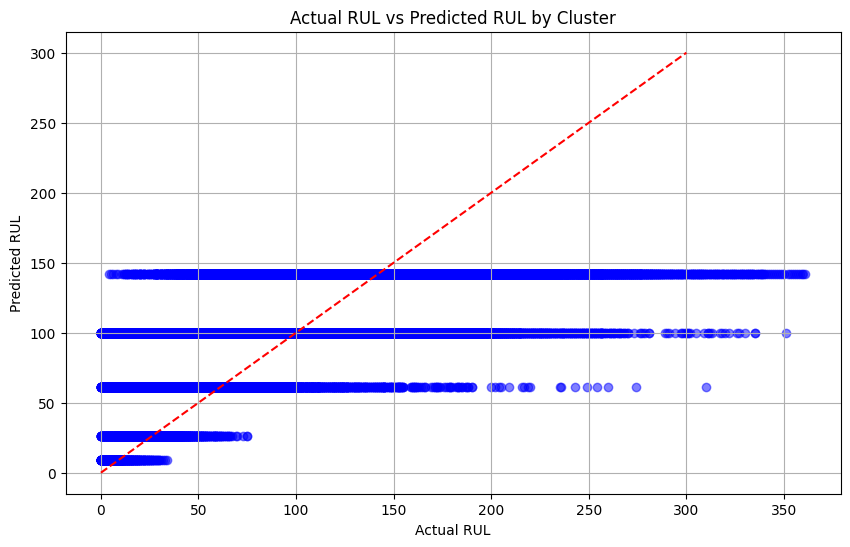

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(train_df['RUL'], train_df['cluster'].map(cluster_rul.set_index('cluster')['RUL']), color='blue', alpha=0.5)
plt.plot([0, 300], [0, 300], color='red', linestyle='--')
plt.title('Actual RUL vs Predicted RUL by Cluster')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.grid(True)
plt.show()

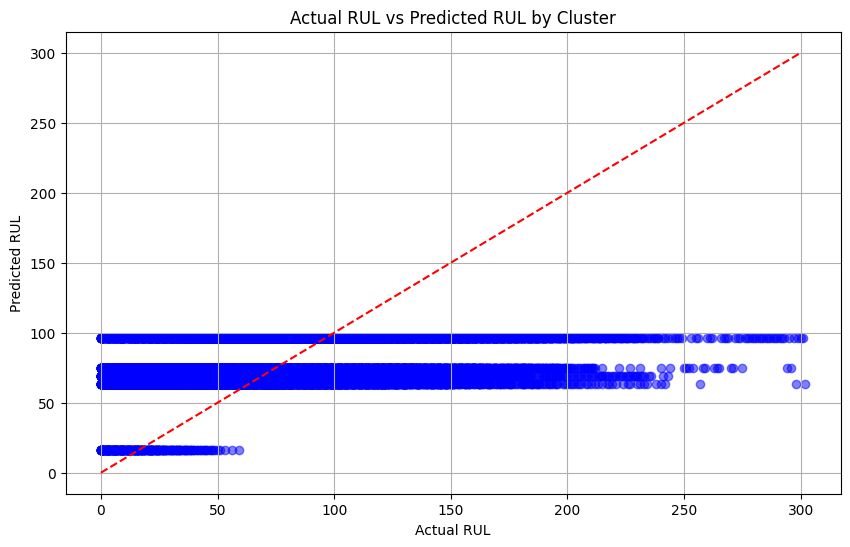

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(test_df['RUL'], test_df['cluster'].map(cluster_rul.set_index('cluster')['RUL']), color='blue', alpha=0.5)
plt.plot([0, 300], [0, 300], color='red', linestyle='--')
plt.title('Actual RUL vs Predicted RUL by Cluster')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.grid(True)
plt.show()

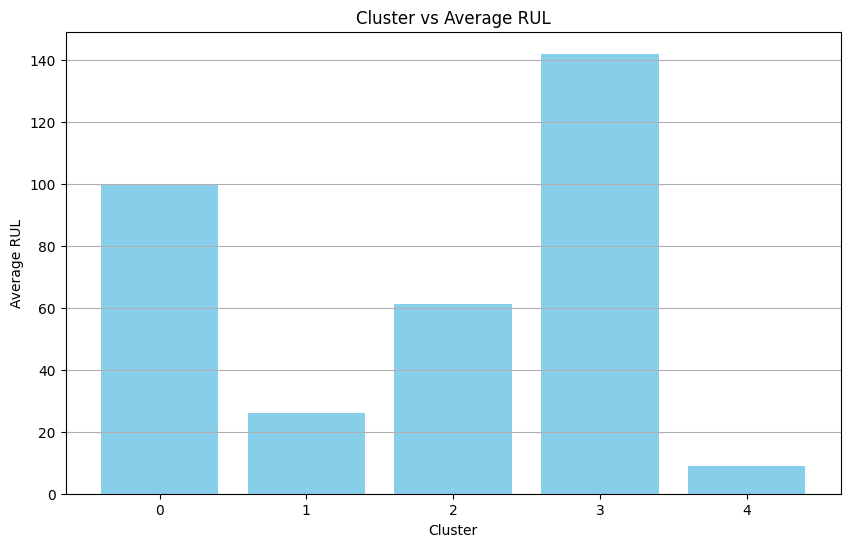

In [18]:
plt.figure(figsize=(10, 6))
plt.bar(cluster_rul['cluster'], cluster_rul['RUL'], color='skyblue')
plt.title('Cluster vs Average RUL')
plt.xlabel('Cluster')
plt.ylabel('Average RUL')
plt.xticks(cluster_rul['cluster'])
plt.grid(axis='y')
plt.show()